## Compare detected face locations in different pliers face detection methods


### Tools that detect faces:

* Google Cloud Vision API
* Clarifai
* pliers itself


### Common measures
* boundaries of faces


### Ways to assess similarity
* Eucledian distance between coordinates?

In [1]:
import numpy as np
from os.path import join as opj
from pliers.extractors import (ClarifaiAPIImageExtractor,
                               FaceRecognitionFaceLocationsExtractor, 
                               GoogleVisionAPIFaceExtractor,
                               merge_results)
from pliers.stimuli import ImageStim
from pliers.filters import FrameSamplingFilter

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as patches

from moviepy.editor import *

W0808 15:33:40.365039 140736167261056 warnings.py:110] /Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])

W0808 15:33:40.366341 140736167261056 warnings.py:110] /Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])

W0808 15:33:40.367135 140736167261056 warnings.py:110] /Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [45]:
def plot_boundingBox(img, coords, savename='', title=''):
    """
    Plots face bounding boxes on image.
    
    params
    ------
    
    returns
    -------
    fix,ax : figure and axis for resulting plot
    
    """
    # Plot image
    fig,ax = plt.subplots(1)
    if isinstance(img, str):
        img = mpimg.imread(img)
    imgplot = ax.imshow(img)

    # For each api, add bounding boxes
    allowed_api = ['builtin', 'clarifai', 'google']
    api_colors = {'builtin': 'r', 'clarifai': 'c', 'google': 'b'}
    patch_list = []
    for api in coords.keys():
        if api not in allowed_api:
            raise ValueError(f'expected api specification from on in {allowed_api}, however I got "{api}".') 
        
        api_coords = coords[api]   
        for c in api_coords:
            rect = patches.Rectangle((c[0], c[1]), c[2], c[3],
                                 linewidth=2,
                                 edgecolor=api_colors[api],
                                 facecolor='none',
                                )
            ax.add_patch(rect)
        
        # for legend
        patch = patches.Patch(color=api_colors[api], label=api)
        patch_list.append(patch)


    plt.axis('off')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', handles=patch_list)

    # save
    if savename:
        plt.savefig(savename)
    
    return fig,ax

In [3]:
def extract_bounding(results,
                    api='builtin',
                    stim = 'image', 
                    x=None,
                    y=None):
    """
    Extract bounding box coordinates from a face extraction with pliers build-in tool
    
    params
    ------
    results: pandas dataframe, result of a .to_df() operation on an extraction result
    api: one of 'builtin', 'clarifai', 'google'
    stim: one of 'image' or 'video'
    x, y: stimulus dimensions in pixel
    
    returns
    -------
    coords: dictionary, with one key per face and coordinates in pixel. Order of coords:
            left, bottom, width, height (how matplotlib plots it)
    >>> extract_bounding(result_clarifai, api='clarifai', stimulus='image' x=444, y=600)
    """
    
    def get_wh(top, right, bottom, left):
        box_width = right - left
        box_height = top - bottom
        return box_width, box_height
    
    allowed_api = ['builtin', 'clarifai', 'google']
    if api not in allowed_api:
        raise ValueError(f'expected api specification from on in {allowed_api}, however I got "{api}".') 
    
    # initialize an exmpty dict
    coords = {}
    if api == 'builtin':
        assert x, y != None
        coords['faces'] = []
        for idx, i in results.iterrows():
            top, right, bottom, left = i['face_locations']
            box_width, box_height = get_wh(top, right, bottom, left)
            coords['faces'].append([left, bottom, box_width, box_height])
    
    # Let's deal with Clarifai
    elif api == 'clarifai':
        if stim == 'image':
            assert x, y != None
            coords['faces'] = []
            for idx, i in results.iterrows():
                    top, right, bottom, left = i['top_row'] * y, i['right_col'] * x, i['bottom_row'] * y, i['left_col'] * x
                    box_width, box_height = get_wh(top, right, bottom, left)
                    # extract coordinates and scale them to pixels
                    coords['faces'].append([left, bottom, box_width, box_height])
                
                
        elif stim == 'video':
            # return a dictionary of dictionaries, and index appropriately
            for idx, i in results.iterrows():
                f = i['stim_name']
                if f not in coords.keys():
                    # initialize a list to append to
                    coords[f] = []
                    top, right, bottom, left = i['ClarifaiAPIImageExtractor#top_row'] * y, \
                                                    i['ClarifaiAPIImageExtractor#right_col'] * x, \
                                                    i['ClarifaiAPIImageExtractor#bottom_row'] * y, \
                                                    i['ClarifaiAPIImageExtractor#left_col'] * x
                    box_width, box_height = get_wh(top, right, bottom, left)
                    coords[f].append([left, bottom, box_width, box_height])
                else:
                    top, right, bottom, left = i['ClarifaiAPIImageExtractor#top_row'] * y, \
                                                    i['ClarifaiAPIImageExtractor#right_col'] * x, \
                                                    i['ClarifaiAPIImageExtractor#bottom_row'] * y, \
                                                    i['ClarifaiAPIImageExtractor#left_col'] * x
                    box_width, box_height = get_wh(top, right, bottom, left)
                    # add to existing frame layer
                    coords[f].append([left, bottom, box_width, box_height])
                    
    # Let's deal with Google            
    elif api == 'google':
        if stim == 'image':
            coords['faces'] = []
            for idx, i in results.iterrows():
                co = [i['fdBoundingPoly_vertex4_x'], # bottom_left_x
                      i['fdBoundingPoly_vertex1_y'], # top_left_y
                      i['fdBoundingPoly_vertex3_x'] - \
                           i['fdBoundingPoly_vertex4_x'], # width: bottom_right_x - bottom_left_x
                      i['fdBoundingPoly_vertex3_y'] - \
                           i['fdBoundingPoly_vertex2_y'] # height: bottom_right_y - top_right_y
                      ]
                coords['faces'].append(co)
        elif stim == 'video':
            # return a dictionary of dictionaries, and index appropriately
            for idx, i in results.iterrows():
                f = i['stim_name']
                if f not in coords.keys():
                    # initialize a list to append to
                    coords[f] = []
                    coords[f].append([i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_x'], # bottom_left_x
                              i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex1_y'], # top_left_y
                              i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_x'] - \
                                   i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_x'], # width: bottom_right_x - bottom_left_x
                              i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_y'] - \
                                   i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex2_y'] # height: bottom_right_y - top_right_y
                          ])
                else:
                    # add to existing frame layer
                    coords[f].append([i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_x'], # bottom_left_x
                               i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex1_y'], # top_left_y
                               i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_x'] - \
                                   i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex4_x'], # width: bottom_right_x - bottom_left_x
                               i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex3_y'] - \
                                   i['GoogleVisionAPIFaceExtractor#fdBoundingPoly_vertex2_y'] # height: bottom_right_y - top_right_y
                              ])
            
    return coords

In [4]:
def write_annotatedVideo(img_list, savename, audio=None):
    """
    Creates video from images with specified duration.
    
    params
    ------
    img_list : list of list, with each inner list specifying a path to an image and a duration
    savename : str, where to save movie file
    audio : str, optional argument for adding audio to movie
    
    >>> img_list = [['img1.jpj', .5], ['img2.jpg', .5]]
    >>> extract_bounding(img_list, savename='ex_video.mp4', audio='ex_aud.mp3')
    """
    
    # generate clips
    clips_list = []
    for img in img_list:
        clip = ImageClip(img[0], duration=img[1])
        clips_list.append(clip)

    # concatenate image clips
    print('Making video...')

    # Concat clips
    newMovie = concatenate_videoclips(clips_list) 

    # Add audio
    if audio:
        audio_clip = AudioFileClip(audio)
        newMovie = newMovie.set_audio(audio_clip)

    # Write movie
    newMovie.write_videofile(savename, fps=24)


In [ ]:
# define static test images (single and many faces)
img_pth = opj('../', 'data', 'obama.jpg')
img_pth_many = opj('../', 'data', 'thai_people.jpg')
stim = ImageStim(img_pth)
stim_many = ImageStim(img_pth_many)


In [ ]:
# the results of the face detection are given relative to stimulus size. Let's get the image dimensions in pixel
y, x = stim.data.shape[:2]
print(f'the one-face picture is {x} pixel x {y} pixel in size')

y2, x2 = stim_many.data.shape[:2]
print(f'the many-face picture is {x2} pixel x {y2} pixel in size')

In [ ]:
# quick overview of the pictures
plt_img = mpimg.imread(img_pth)
plt_img2 = mpimg.imread(img_pth_many)
plt.figure(1)
plt.subplot(211)
plt.imshow(plt_img)

plt.subplot(212)
plt.imshow(plt_img2)

plt.axis('off')
plt.show()


### pliers face detection

In [ ]:
ext_pliers = FaceRecognitionFaceLocationsExtractor()
# for single face
result_pliers = ext_pliers.transform(stim).to_df()
# for many faces stimulus
result_pliers_many = ext_pliers.transform(stim_many).to_df()

In [ ]:
# extract faces for single and multi-face images from pliers-builtin, and plot them
for res, im, x_dim, y_dim in [(result_pliers, img_pth, x, y), (result_pliers_many, img_pth_many, x2, y2)]:
    d = extract_bounding(res, x=x_dim, y=y_dim)
    for k, i in d.items():
       # top, right, bottom, left = i
        box_width = right-left
        box_height = top-bottom
      #  coords = [[left, bottom, box_width, box_height]]
        plot_boundingBox(im, i, title='Pliers builtin')

In [ ]:
i

### clarifai face detection

In [ ]:
# the clarifai extraction needs a model and an api key
model='face' 
ext_clarifai = ClarifaiAPIImageExtractor(api_key='d53d5755b7514b87877df990f2d0bbd4',
                                         model=model)
result_clarifai = ext_clarifai.transform(stim).to_df()

# for many faces
result_clarifai_many = ext_clarifai.transform(stim_many).to_df()

In [ ]:
# extract faces for single and multi-face images from pliers-builtin, and plot them
for res, im, x_dim, y_dim in [(result_clarifai, img_pth, x, y), (result_clarifai_many, img_pth_many, x2, y2)]:
    d = extract_bounding(res, api='clarifai', x=x_dim, y=y_dim)
    for k, i in d.items():
        top, right, bottom, left = i
        box_width = right-left
        box_height = top-bottom
        coords = [[left, bottom, box_width, box_height]]
        plot_boundingBox(im, coords, 'Clarifai')

### Google Cloud vision API face detection

In [ ]:
#ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/home/adina/NeuroHackademy-02c15db15c2a.json')
ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/Users/Mai/NeuroHackademy-02c15db15c2a.json')
#result_google = ext_google.transform(stim_many).to_df()
results_google = ext_google.transform(stim).to_df()
results_google

In [ ]:
# Google has "wide" and "narrow" bounding boxes. Here we get the wide bounding box

#result_google.to_dict(orient='records')
# vertex coordinates are in the same scale as the original image.
# vertices are in order top-left, top-right, bottom-right, bottom-left.
top_left_x = results_google['boundingPoly_vertex1_x'][0]
top_right_x = results_google['boundingPoly_vertex2_x'][0]
bottom_right_x = results_google['boundingPoly_vertex3_x'][0]
bottom_left_x = results_google['boundingPoly_vertex4_x'][0]

top_left_y = results_google['boundingPoly_vertex1_y'][0]
top_right_y = results_google['boundingPoly_vertex2_y'][0]
bottom_right_y = results_google['boundingPoly_vertex3_y'][0]
bottom_left_y = results_google['boundingPoly_vertex4_y'][0]

print(top_left_x, top_right_x, bottom_right_x, bottom_left_x)
print(top_left_y, top_right_y, bottom_right_y, bottom_left_y)

In [ ]:
# # Plot bounding on image 
box_width = bottom_right_x - bottom_left_x
box_height =  bottom_right_y - top_right_y
coords_google_wide = [[bottom_left_x, top_left_y, box_width, box_height]]

plot_boundingBox(img_pth, coords_google_wide, title='Google: wide face bounding box')

In [ ]:
# Google has "wide" and "narrow" bounding boxes. Here we get the narrow bounding box

# vertex coordinates are in the same scale as the original image.
# vertices are in order top-left, top-right, bottom-right, bottom-left.
top_left_x = results_google['fdBoundingPoly_vertex1_x'][0]
top_right_x = results_google['fdBoundingPoly_vertex2_x'][0]
bottom_right_x = results_google['fdBoundingPoly_vertex3_x'][0]
bottom_left_x = results_google['fdBoundingPoly_vertex4_x'][0]

top_left_y = results_google['fdBoundingPoly_vertex1_y'][0]
top_right_y = results_google['fdBoundingPoly_vertex2_y'][0]
bottom_right_y = results_google['fdBoundingPoly_vertex3_y'][0]
bottom_left_y = results_google['fdBoundingPoly_vertex4_y'][0]

print(top_left_x, top_right_x, bottom_right_x, bottom_left_x)
print(top_left_y, top_right_y, bottom_right_y, bottom_left_y)

In [ ]:

# Plot bounding on image 
box_width = bottom_right_x - bottom_left_x
box_height =  bottom_right_y - top_right_y
coords_google_narrow = [[bottom_left_x, top_left_y, box_width, box_height]]
plot_boundingBox(img_pth, coords_google_narrow, title = 'Google: narrow face bounding box')


### Compare different face bounding boxes

In [ ]:
# let's start with looking at the coords
print('pliers: ' + str(coords_pliers))
print('clarifai: ' + str(coords_clarifai))
print('google (wide): ' + str(coords_google_wide))
print('google (narrow): ' + str(coords_google_narrow))

In [ ]:
# Plot on the same figure

# Make a dictionary with coords
face_apis = ['pliers', 'clarifai', 'google_wide', 'google_narrow']
coord_dict = dict(zip(face_apis, [coords_pliers, coords_clarifai, coords_google_wide, coords_google_narrow]))


In [ ]:
frames.get_frame(0).

### Detect faces in a video

In [5]:
# Output dir
out_dir = opj('../', 'output')

# Path to video
video_pth = opj('../', 'data', 'obama_speech.mp4')

# Sample 2 frames per second
sampler = FrameSamplingFilter(hertz=2)
frames = sampler.transform(video_pth)

x = np.shape(frames.get_frame(0).data)[1]
y = np.shape(frames.get_frame(0).data)[0]
print(x)
print(y)

320
240


In [8]:
# Video face extraction with Google
api = 'google'

# Extract using google API
ext_google = GoogleVisionAPIFaceExtractor(discovery_file='/Users/Mai/NeuroHackademy-02c15db15c2a.json')
results_google = ext_google.transform(frames)
results_google = merge_results(results_google, )

W0808 15:34:44.947290 140736167261056 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mai/anaconda/envs/neuroscout/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in

In [9]:
# get bounding boxes for every frame
coords_dict_google = extract_bounding(results_google, api=api, stim='video')

for i in range(frames.n_frames):
    # get this frame
    f = frames.get_frame(i)
    f_data = f.data
    f_name = f.name

    # get coords
    coords = coords_dict_google[f_name]
    
    # plot img with box and save    
    savename = opj(out_dir, 'img_' + str(i).zfill(3) + '_' + api + '.jpg')
    #plot_boundingBox(f_data, coords, savename)

In [11]:
# Video face extraction with Clarifai
api = 'clarifai'

model='face' 
ext_clarifai = ClarifaiAPIImageExtractor(api_key='d53d5755b7514b87877df990f2d0bbd4',
                                         model=model)
result_clarifai = ext_clarifai.transform(frames)
result_clarifai = merge_results(result_clarifai)


1it [00:06,  6.96s/it]
Stim: 18it [00:00, 31522.95it/s]


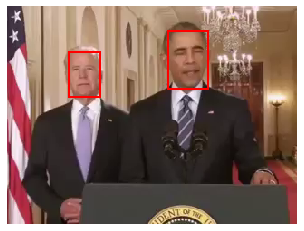

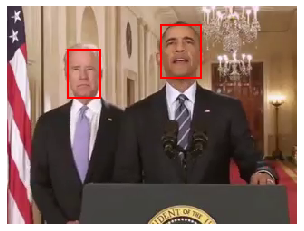

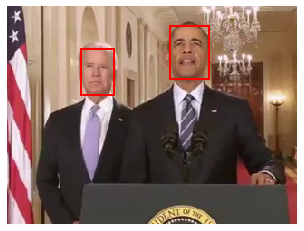

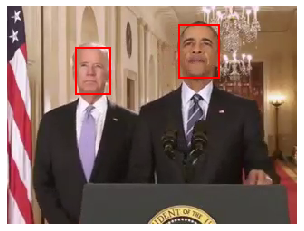

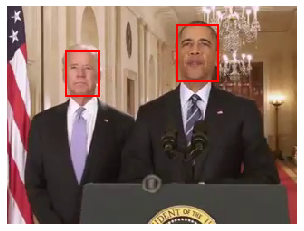

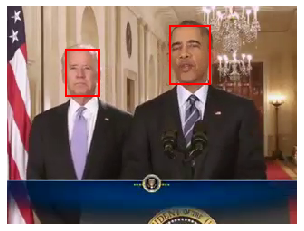

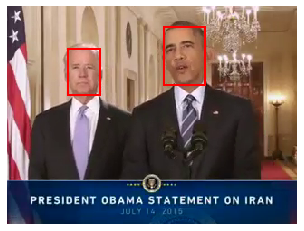

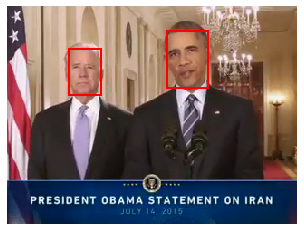

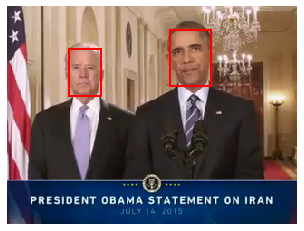

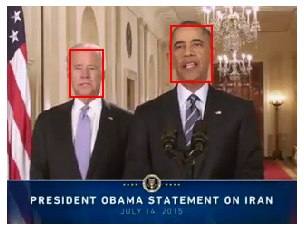

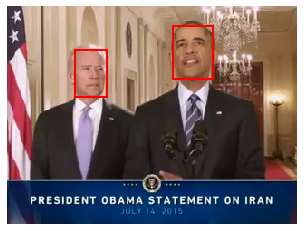

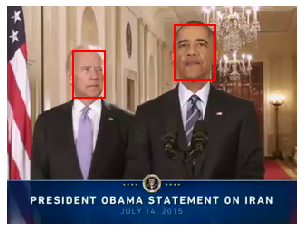

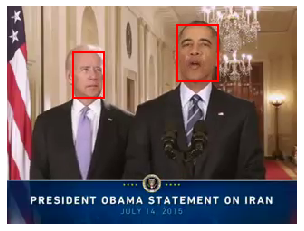

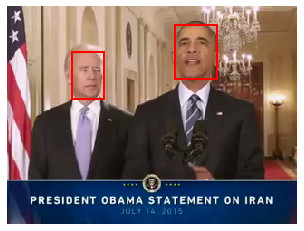

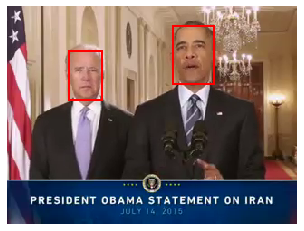

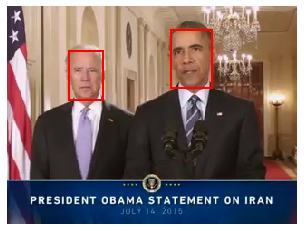

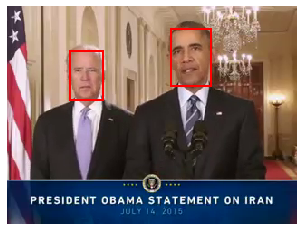

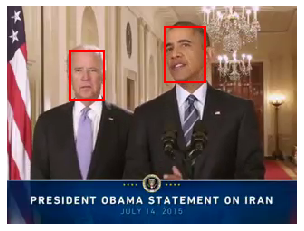

In [12]:
# get bounding boxes for every frame
coords_dict_clarifai = extract_bounding(result_clarifai, api=api, stim='video', x=x, y=y)

for i in range(frames.n_frames):
    # get this frame
    f = frames.get_frame(i)
    f_data = f.data
    f_name = f.name

    # get coords
    coords = coords_dict_clarifai[f_name]
    
    # plot img with box and save    
    savename = opj(out_dir, 'img_' + str(i).zfill(3) + '_' + api + '.jpg')
    plot_boundingBox(f_data, coords, savename)

In [49]:
# Video extraction with pliers
api = 'pliers'
ext_pliers = FaceRecognitionFaceLocationsExtractor()
result_pliers = ext_pliers.transform(frames)
result_pliers = merge_results(result_pliers)



Stim: 18it [00:01, 17.15it/s]


,object_id,filename,source_file,onset,order,duration,class,history,stim_name,FaceRecognitionFaceLocationsExtractor#face_locations
0,0,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,0.0,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[0],"(36, 223, 79, 180)"
1,1,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,0.0,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[0],"(58, 101, 94, 65)"
2,0,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,0.5,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[6],"(26, 213, 70, 170)"
3,1,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,0.5,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[6],"(58, 101, 94, 65)"
4,0,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,1.0,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[12],"(58, 117, 94, 81)"
5,1,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,1.0,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[12],"(31, 223, 74, 180)"
6,0,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,1.5,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[18],"(26, 232, 70, 189)"
7,1,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,1.5,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[18],"(58, 109, 94, 73)"
8,0,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,2.0,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[24],"(58, 97, 94, 61)"
9,1,NaN,/Users/Mai/Projects/tutorials/pliers/natstim_n...,2.0,NaN,0.50,VideoFrameStim,VideoStim->FrameSamplingFilter/VideoFrameColle...,frame[24],"(26, 233, 78, 181)"


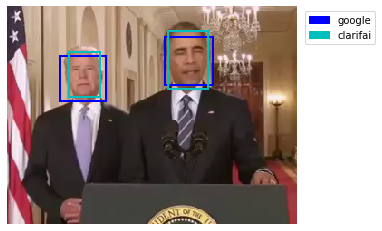

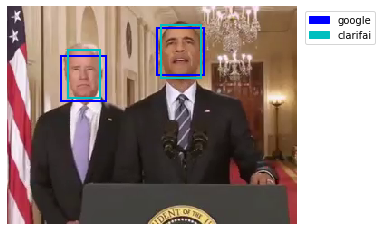

In [46]:
# Make images

coords_all = {'google': coords_dict_google, 'clarifai': coords_dict_clarifai}

include_apis = ['google', 'clarifai']

for i in range(2):
    # get this frame
    f = frames.get_frame(i)
    f_data = f.data
    f_name = f.name

    # get coords for included apis
    frame_coords = {}
    for api in include_apis:
        frame_coords[api] = coords_all[api][f_name]
    
    # plot img with box and save    
    savename = opj(out_dir, 'img_' + str(i).zfill(3) + '_googleClarifai.jpg')
    plot_boundingBox(f_data, frame_coords, savename=savename)

In [21]:
frame_coords['google']

[[165, 23, 52, 52], [59, 54, 50, 50]]

In [ ]:
# Generate movies

# get list of clips and durations
img_dir = opj('../', 'output')
img_list = []
for i in range(18):
    img_list.append([opj(img_dir,'img_'+str(i).zfill(3)+'.jpg'), .5 ])

savename = opj(out_dir, 'obama_speech_annotated.mp4')
audio = '../data/obama_speech_audio.mp3'
write_annotatedVideo(img_list, savename=savename, audio=audio)

In [ ]:
b = None
if b:
    print('a')